## Project Summary
#### This notebook presents an end-to-end solution for the bank marketing term deposit prediction challenge.

#### 1. Data Loading & EDA:
##### Loaded train and test datasets, reviewed feature types, and visualized distributions (target, key features, job categories, and numeric correlations).

#### 2. Preprocessing & Feature Engineering:
##### Combined datasets for consistent encoding, used label encoding for categoricals, created new features, then split data back for modeling.

#### 3. Modeling:
##### Implemented stratified K-fold cross-validation with a LightGBM classifier to handle class imbalance and obtain robust validation scores.

#### 4. Evaluation:
##### Assessed model performance using ROC AUC, and plotted feature importances to interpret results.

#### 5. Prediction & Submission:
##### Made test-set probability predictions and prepared the submission file in Kaggle’s required format.

In [ ]:
# Imports & Setup
import pandas as pd
import numpy as np
import os
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
pd.set_option('display.max_columns', 100)

#### Data Loading

In [32]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
SUB_PATH = 'sample_submission.csv'


train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SUB_PATH)

train.shape, test.shape

((750000, 18), (250000, 17))

In [34]:
display(train.head())
display(test.head())

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


#### Info

In [36]:
print(train.info())
print(train.isnull().sum())
print(test.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB
None
id           0
age          0
jo

#### Target Distribution

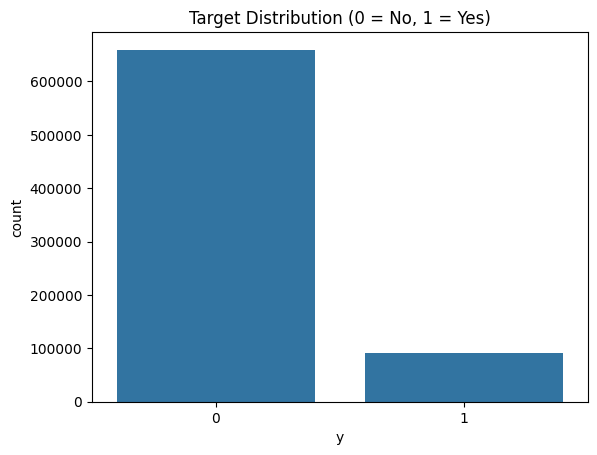

y
0    0.879349
1    0.120651
Name: proportion, dtype: float64


In [41]:
sns.countplot(x='y', data=train)
plt.title('Target Distribution (0 = No, 1 = Yes)')
plt.show()

print(train['y'].value_counts(normalize=True))

#### Categorical columns

In [45]:
cat_features = train.select_dtypes(include='object').columns.tolist()
cat_features = [c for c in cat_features if c != 'y' and c != 'id']
print(cat_features)

# Numerical columns
num_features = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features = [c for c in num_features if c not in ['y', 'id']]
print(num_features)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


####  Exploratory Data Analysis: Numeric

In [49]:
train[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,750000.0,40.926395,10.098829,18.0,33.0,39.0,48.0,95.0
balance,750000.0,1204.067397,2836.096759,-8019.0,0.0,634.0,1390.0,99717.0
day,750000.0,16.117209,8.250832,1.0,9.0,17.0,21.0,31.0
duration,750000.0,256.229144,272.555662,1.0,91.0,133.0,361.0,4918.0
campaign,750000.0,2.577008,2.718514,1.0,1.0,2.0,3.0,63.0
pdays,750000.0,22.412733,77.319998,-1.0,-1.0,-1.0,-1.0,871.0
previous,750000.0,0.298545,1.335926,0.0,0.0,0.0,0.0,200.0


#### Summary 

In [53]:
for col in cat_features:
    print(f'{col}: {train[col].nunique()} unique values')
    print(train[col].value_counts(), "\n")

job: 12 unique values
job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64 

marital: 3 unique values
marital
married     480759
single      194834
divorced     74407
Name: count, dtype: int64 

education: 4 unique values
education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64 

default: 2 unique values
default
no     737151
yes     12849
Name: count, dtype: int64 

housing: 2 unique values
housing
yes    411288
no     338712
Name: count, dtype: int64 

loan: 2 unique values
loan
no     645023
yes    104977
Name: count, dtype: int64 

contact: 3 unique values
contact
cellular     486655
unknown      231627
telephone     31718
Name: count, dtype: int64 

month: 12 uni

#### Concatenate train and test

In [57]:
train['is_train'] = True
test['is_train'] = False
data_all = pd.concat([train, test], axis=0, ignore_index=True)
print(data_all.shape)

(1000000, 19)


#### Label encode categoricals

In [61]:
for col in cat_features:
    le = LabelEncoder()
    data_all[col] = le.fit_transform(data_all[col].astype(str))

In [63]:
train = data_all[data_all['is_train']].copy()
test = data_all[~data_all['is_train']].copy()
train.drop(['is_train'], axis=1, inplace=True)
test.drop(['is_train', 'y'], axis=1, errors='ignore', inplace=True)

# Reindex
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

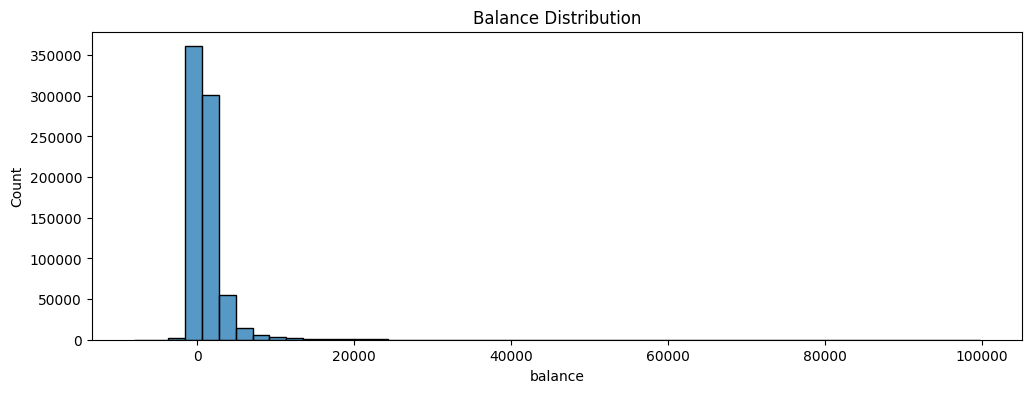

In [65]:
plt.figure(figsize=(12,4))
sns.histplot(train['balance'], bins=50)
plt.title("Balance Distribution")
plt.show()

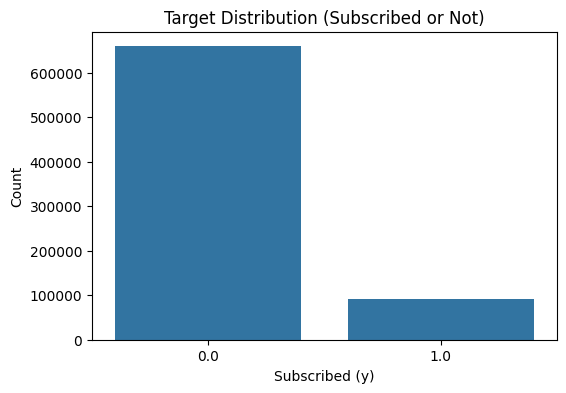

In [117]:
plt.figure(figsize=(6,4))
sns.countplot(x='y', data=train)
plt.title('Target Distribution (Subscribed or Not)')
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')
plt.show()

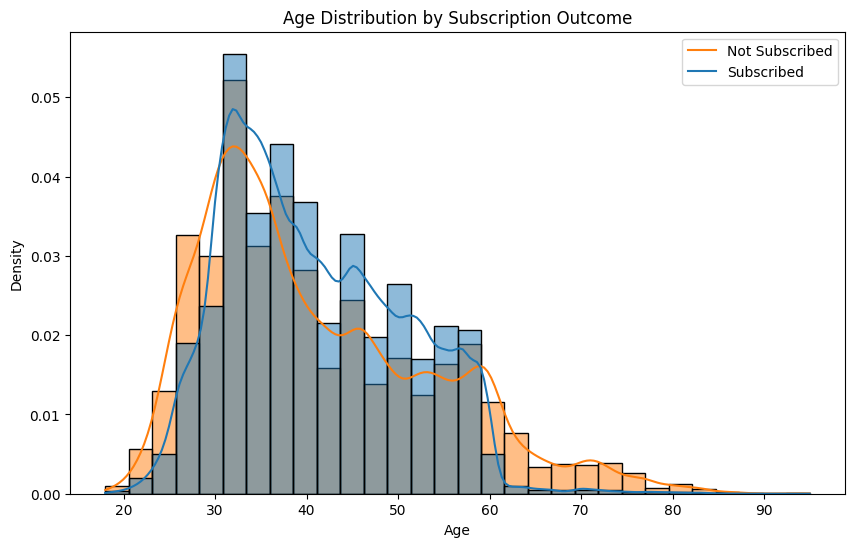

In [119]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x="age", hue="y", bins=30, stat="density", common_norm=False, kde=True)
plt.title('Age Distribution by Subscription Outcome')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(labels=["Not Subscribed", "Subscribed"])
plt.show()

In [67]:
train['duration_per_campaign'] = train['duration'] / (train['campaign']+1)
test['duration_per_campaign'] = test['duration'] / (test['campaign']+1)

#### Matrices

In [71]:
features = [c for c in train.columns if c not in ['id', 'y']]
X = train[features]
y = train['y']
X_test = test[features]

#### Cross Validation 

In [77]:
NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

In [105]:
def train_lgb(X, y, X_test, skf, cat_cols=None):
    oof = np.zeros(X.shape[0])
    preds = np.zeros(X_test.shape[0])
    scores = []
    models = []
    
    lgb_params = {
        'objective': 'binary',
        'learning_rate': 0.01,
        'n_estimators': 5000,
        'reg_alpha': 1,
        'reg_lambda': 1,
        'random_state': SEED,
        'n_jobs': -1,
        'metric': 'auc',
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'min_child_samples': 20,
        'device': 'cpu',
        'verbose': -1
    }
    
    from lightgbm import early_stopping

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = lgb.LGBMClassifier(**lgb_params)

       

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            callbacks=[early_stopping(stopping_rounds=100)]
        )

        oof[val_idx] = model.predict_proba(X_val)[:,1]
        preds += model.predict_proba(X_test)[:,1] / NFOLDS
        score = roc_auc_score(y_val, oof[val_idx])
        scores.append(score)
        print(f'Fold {fold+1} AUC: {score:.5f}')
        models.append(model)
    print(f'Mean CV AUC: {np.mean(scores):.5f} +- {np.std(scores):.5f}')
    return oof, preds, models

#### LIGHTGBM: Train and Validate

In [109]:
oof_lgb, test_lgb, lgb_models = train_lgb(X, y, X_test, skf)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.968997
Fold 1 AUC: 0.96900
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.968031
Fold 2 AUC: 0.96803
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.96792
Fold 3 AUC: 0.96792
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.968984
Fold 4 AUC: 0.96898
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.968353
Fold 5 AUC: 0.96835
Mean CV AUC: 0.96846 +- 0.00046


In [111]:
final_predictions = test_lgb

C:\Users\Raj\AppData\Local\Temp\ipykernel_23348\1931444043.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='job', data=train, order=train['job'].value_counts().index, palette="viridis")


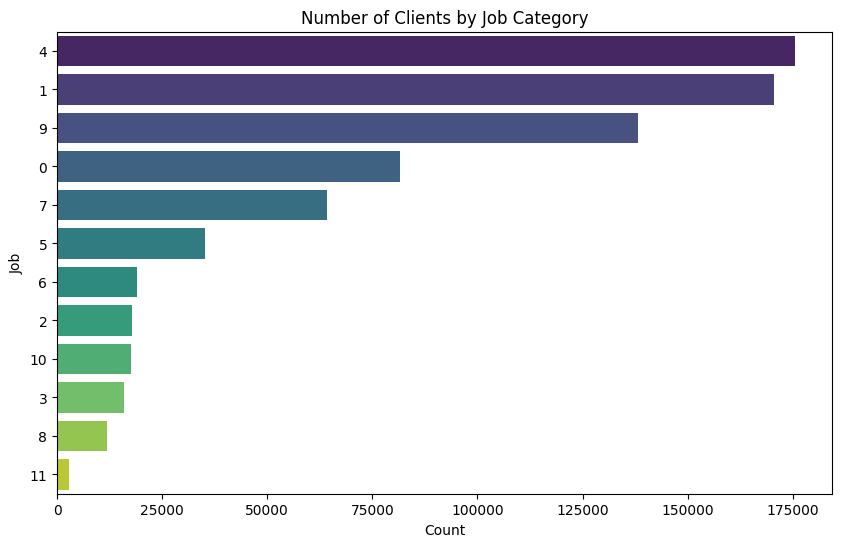

In [123]:
plt.figure(figsize=(10,6))
sns.countplot(y='job', data=train, order=train['job'].value_counts().index, palette="viridis")
plt.title('Number of Clients by Job Category')
plt.xlabel('Count')
plt.ylabel('Job')
plt.show()

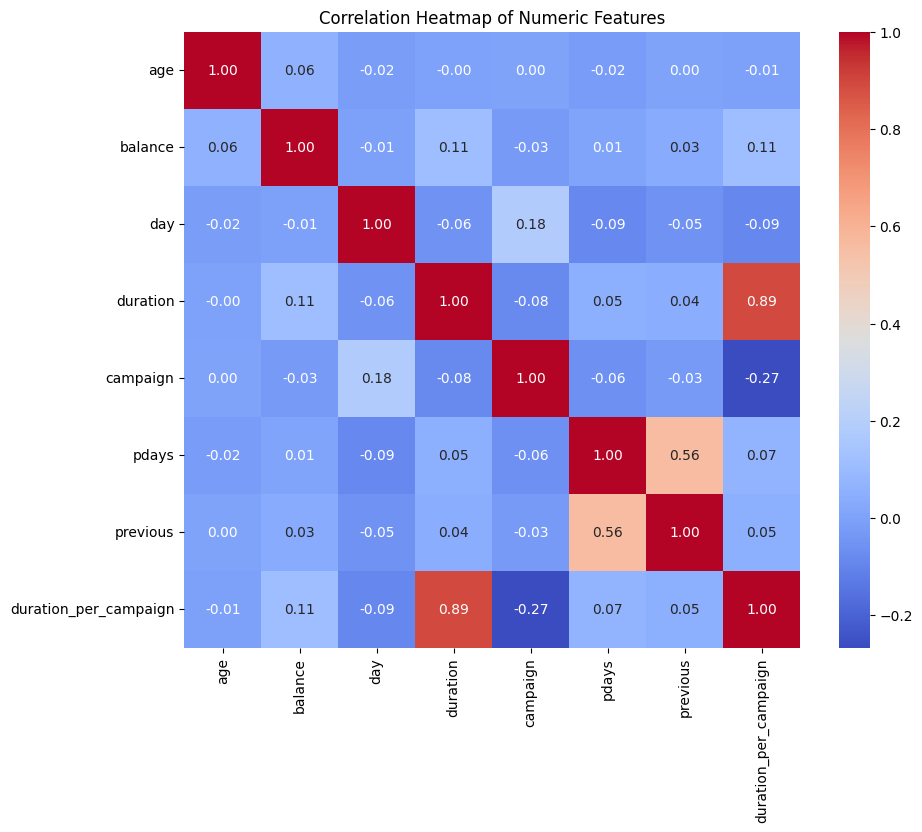

In [125]:
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'y' in numeric_cols: numeric_cols.remove('y')
if 'id' in numeric_cols: numeric_cols.remove('id')
plt.figure(figsize=(10,8))
sns.heatmap(train[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

#### Final Submission 

In [128]:
submission = sample_submission.copy()
submission['y'] = final_predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,id,y
0,750000,0.002817
1,750001,0.092360
2,750002,0.000329
3,750003,0.000178
4,750004,0.022537
